# Exercise 1: Wiener Filter

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### (a) Optimal filter weights

In [2]:
R_x = np.array([[5, -1, -2],[-1, 5, -1],[-2, -1, 5]])
r_yx = np.array([1, 5.3, -3.9]).reshape((3,1))
R_x_inv = np.linalg.inv(R_x)

w_o = np.dot(R_x_inv,  r_yx)
print("Optimal weights are:\n", w_o)
print("")
print("inverse of R_x is:\n", R_x_inv)


Optimal weights are:
 [[ 0.2]
 [ 1. ]
 [-0.5]]

inverse of R_x is:
 [[0.26373626 0.07692308 0.12087912]
 [0.07692308 0.23076923 0.07692308]
 [0.12087912 0.07692308 0.26373626]]


# Exercise 2: Steepest Gradient Descent

### (b) Calculate eigenvalues of R_x

In [3]:
eigenvalues = np.linalg.eigvals(R_x)
print("eigenvalues of R_x are:\n", eigenvalues)
# alpha between 0 and 1/7

eigenvalues of R_x are:
 [2.26794919 7.         5.73205081]


### (c) Implementing the filter update rule of the GD algorithm 

#### Loading data

In [4]:
# Load the CSV file into a DataFrame
df = pd.read_csv('assignment1_data.csv', header=None)

# Assign column names assuming the first column is x and the second column is y
df.columns = ['x', 'y']

# Print the DataFrame to verify the data
print(df)

            x        y
0     0.00000  0.34438
1    -1.10410 -0.17451
2     0.31334 -0.66892
3    -0.88409 -0.14649
4    -1.96720 -0.82132
...       ...      ...
9995 -0.32324  1.42040
9996  1.03690 -0.61886
9997 -3.23190  0.46254
9998  3.57420 -3.25900
9999  1.42070  5.26790

[10000 rows x 2 columns]


#### Initialize filter & Implement the adaptive filter to perform N iterations.


In [5]:
# Initialize weights and learning rate
weights = np.array([0,0,0]).reshape(3,1)
alpha = 0.01 # Should be between 0 and 1/7

J, weights_history = [], []

for i in range(2,len(df)):

    #Predict
    x = np.array([df['x'][i-2],df['x'][i-1],df['x'][i]]).reshape(1,3)[0] #input
    y_hat = np.dot(x, weights)[0] #Prediction

    #Error
    y = df['y'][i] #ground truth y
    J.append(((y-y_hat)**2)) #calculate MSE loss

    #Update
    weights_history.append(weights) #Add current weights to history
    weights = weights + 2*alpha*(r_yx - np.dot(R_x, weights)) #Update weights according to known statistics

print("Final weights are:\n", weights)

Final weights are:
 [[ 0.2]
 [ 1. ]
 [-0.5]]


#### Plotting trajectory of the filter coefficients, together with a contour plot of the objective function J

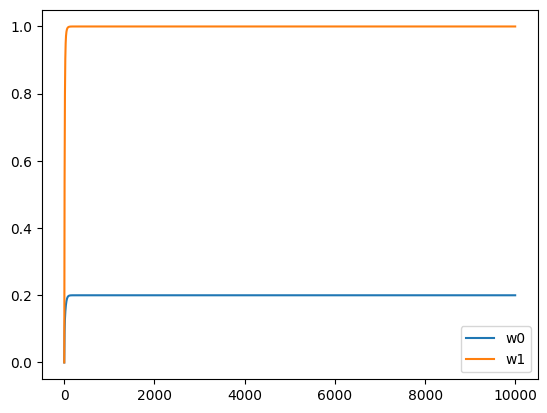

In [6]:
w0,w1,w2 = [],[],[]
for i in range(len(weights_history)):
    w0.append(weights_history[i][0])
    w1.append(weights_history[i][1])
    w2.append(weights_history[i][2])

# Show the convergence of the weights
plt.plot(w0, label='w0')
plt.plot(w1, label='w1')
plt.legend()
plt.show()

# Exercise 3: Newton’s Method

# Exercise 4: LMS and NLMS

# Exercise 5: RLS

# Exercise 6

#### (a) Importing the data and plotting a sample of the dataset.

Number of training examples: 60000
Number of test examples: 10000


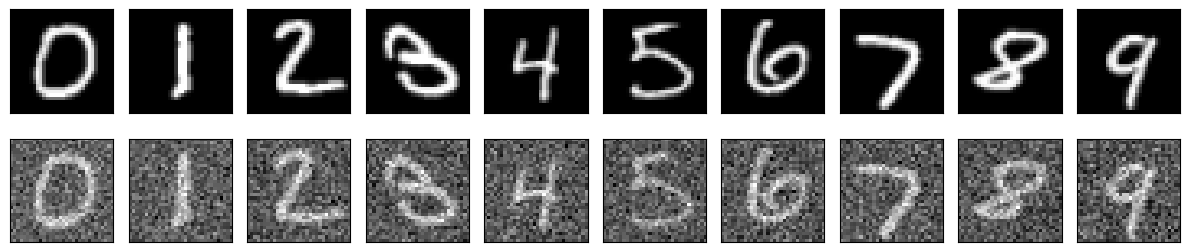

In [7]:
# Import necessary libraries
import torch
from torch import nn
from torchvision import transforms, datasets
from MNIST_dataloader import create_dataloaders
from torch.utils.data import random_split

# Define parameters
data_loc = '.'
batch_size = 64

# Create dataloader
train_loader, test_loader = create_dataloaders(data_loc, batch_size)

print("Number of training examples:", len(train_loader.dataset))
print("Number of test examples:", len(test_loader.dataset))

# Get some examples
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)

# Plot a sample of the dataset
plt.figure(figsize=(12, 3))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_clean_example[i, 0, :, :], cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 10, i + 11)
    plt.imshow(x_noisy_example[i, 0, :, :], cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.savefig("data_examples.png", dpi=300, bbox_inches='tight')
plt.show()

#### Splitting the data into the trainingvalidation-test sets

In [8]:
# Set the seed for the random number generator
torch.manual_seed(42)

# Create dataloaders
train_loader, test_loader = create_dataloaders(data_loc, batch_size)

# Get the length of the train dataset
train_dataset_length = len(train_loader.dataset)

# Define the length of the validation dataset (e.g., 20% of the train dataset)
validation_dataset_length = int(train_dataset_length * 0.2)
train_dataset_length -= validation_dataset_length

# Split the train dataset into a new train dataset and a validation dataset
train_dataset, validation_dataset = random_split(train_loader.dataset, [train_dataset_length, validation_dataset_length])

# Create a DataLoader for the new train dataset and the validation dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)

print(f'Train dataset length: {len(train_loader.dataset)}')
print(f'Validation dataset length: {len(validation_loader.dataset)}')
print(f'Test dataset length: {len(test_loader.dataset)}')

Train dataset length: 48000
Validation dataset length: 12000
Test dataset length: 10000


#### (b) Building the fully connected network with linear layers

In [9]:
class DenoisingNet(nn.Module):
    def __init__(self):
        super(DenoisingNet, self).__init__()
        self.fc1 = nn.Linear(32*32, 512)  # Assuming the input images are 32x32
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 32*32)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = x.view(x.size(0), 1, 32, 32)  # Reshape the output back to a 2D image
        return x

#### Prediction with the untrained network using the validation set, to ensure that the model can actually run

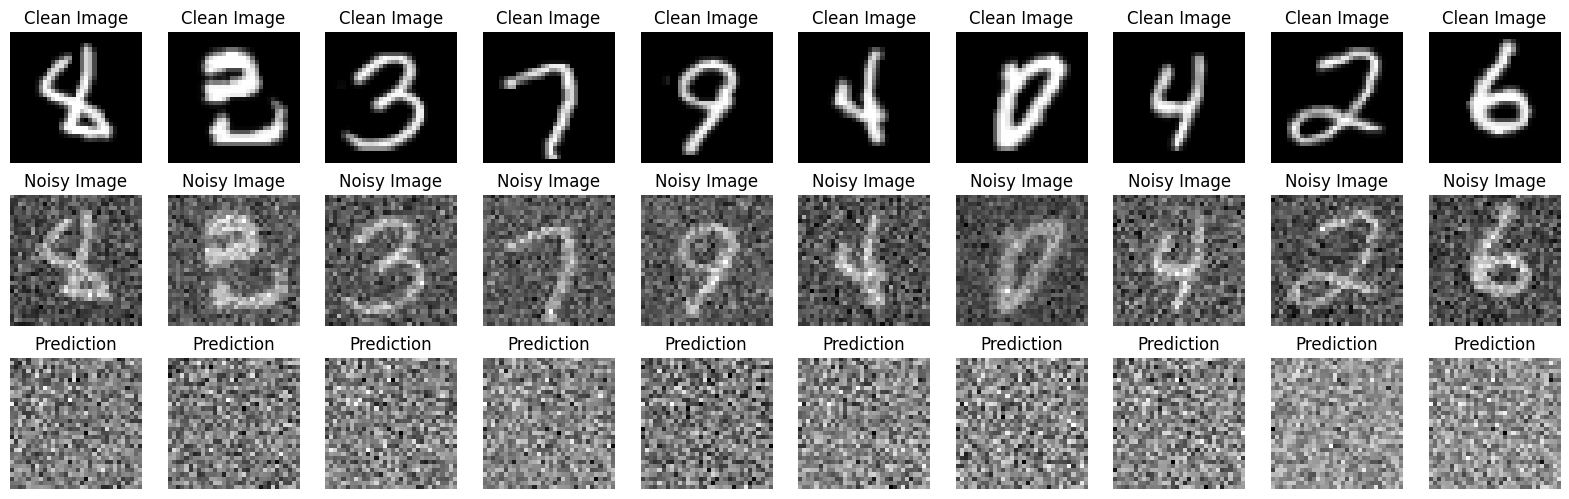

In [10]:
# Instantiate the model
model = DenoisingNet()

# Get some test data
examples = enumerate(validation_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)

# Make a prediction with the untrained network
outputs = model(x_noisy_example)

# Plot the first 10 test images, noisy images and their corresponding predictions
fig, axs = plt.subplots(3, 10, figsize=(20, 6))

for i in range(10):
    # Plot the clean image
    axs[0, i].imshow(x_clean_example[i].view(32, 32).detach().numpy(), cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title('Clean Image')

    # Plot the noisy image
    axs[1, i].imshow(x_noisy_example[i].view(32, 32).detach().numpy(), cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title('Noisy Image')

    # Plot the prediction
    axs[2, i].imshow(outputs[i].view(32, 32).detach().numpy(), cmap='gray')
    axs[2, i].axis('off')
    axs[2, i].set_title('Prediction')

plt.show()

#### (c) Training the model with SGD

In [11]:
# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f'CUDA is available!  Training on {device}.')
else:
    print(f'CUDA is not available.  Training on {device}.')

CUDA is available!  Training on cuda.


In [12]:
# Instantiate the model
model = DenoisingNet().to(device)
model.train()

learning_rate = 0.0005
epochs = 10

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Lists to store losses
train_losses = []
validation_losses = []

# Train the model
for epoch in range(epochs):  # loop over the dataset multiple times
    epoch_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, noisy_inputs, _ = data
        inputs, noisy_inputs = inputs.to(device), noisy_inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(noisy_inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # Save the loss for this batch
        train_losses.append(loss.item())

        # Add the loss for this batch to the total loss for this epoch
        epoch_loss += loss.item()

    # Calculate the average loss for this epoch
    epoch_loss /= len(train_loader)

    print(f'Epoch {epoch + 1}, Average Training Loss: {epoch_loss}')

    # Validate the model
    validation_loss = 0.0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in validation_loader:
            inputs_val, noisy_inputs_val, _ = data
            inputs_val, noisy_inputs_val = inputs_val.to(device), noisy_inputs_val.to(device)
            outputs = model(noisy_inputs_val)
            loss = criterion(outputs, inputs_val)
            validation_loss += loss.item()

    validation_loss /= len(validation_loader)
    validation_losses.append(validation_loss)
    print(f'Epoch {epoch + 1}, Validation Loss: {validation_losses[-1]}')

    model.train()  # Set the model back to training mode

# Save the model weights
torch.save(model.state_dict(), 'model_weights.pth')

print('Finished Training')

Epoch 1, Average Training Loss: 0.8678340272903442
Epoch 1, Validation Loss: 0.8433894353344086
Epoch 2, Average Training Loss: 0.8152797461350759
Epoch 2, Validation Loss: 0.7830883819372096
Epoch 3, Average Training Loss: 0.7380167526404063
Epoch 3, Validation Loss: 0.6847341745457751
Epoch 4, Average Training Loss: 0.6144363368352255
Epoch 4, Validation Loss: 0.5378675229371862
Epoch 5, Average Training Loss: 0.4608344561258952
Epoch 5, Validation Loss: 0.3903845941766779
Epoch 6, Average Training Loss: 0.3398463906844457
Epoch 6, Validation Loss: 0.29961597903611814
Epoch 7, Average Training Loss: 0.275510457833608
Epoch 7, Validation Loss: 0.25735139886432506
Epoch 8, Average Training Loss: 0.2470162004828453
Epoch 8, Validation Loss: 0.239456731509021
Epoch 9, Average Training Loss: 0.23510596791903177
Epoch 9, Validation Loss: 0.2320418491801049
Epoch 10, Average Training Loss: 0.23014194377263386
Epoch 10, Validation Loss: 0.22890842491959004
Finished Training


#### Plotting the train and validation losses

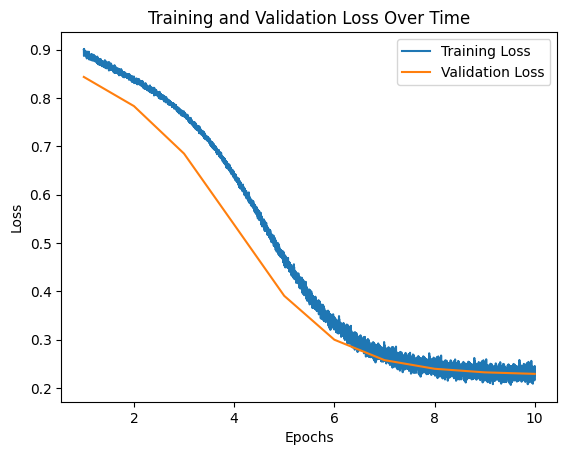

In [13]:
# Create a figure
plt.figure()

# Calculate the epoch for each batch and plot the training loss
epochs_for_each_batch = np.linspace(1, epochs, len(train_losses))
plt.plot(epochs_for_each_batch, train_losses, label='Training Loss')

# Plot the validation loss
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')

# Add a title, x-label, y-label, and a legend
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

#### Evaluating the trained model on test set

In [14]:
# Set the model to evaluation mode
model.eval()

# Initialize the loss
test_loss = 0.0

# No need to track gradients in test phase, it saves memory and computations
with torch.no_grad():
    for data in test_loader:
        # Get the inputs and move them to the device
        clean_images, noisy_images, _ = data
        clean_images, noisy_images = clean_images.to(device), noisy_images.to(device)

        # Forward pass
        outputs = model(noisy_images)

        # Compute the loss
        loss = criterion(outputs, clean_images)

        # Add the loss for this batch to the total loss
        test_loss += loss.item()

# Compute the average test loss
test_loss /= len(test_loader)

print(f'Test Loss: {test_loss}')

Test Loss: 0.23030962695361704


#### Show predictions with trained model

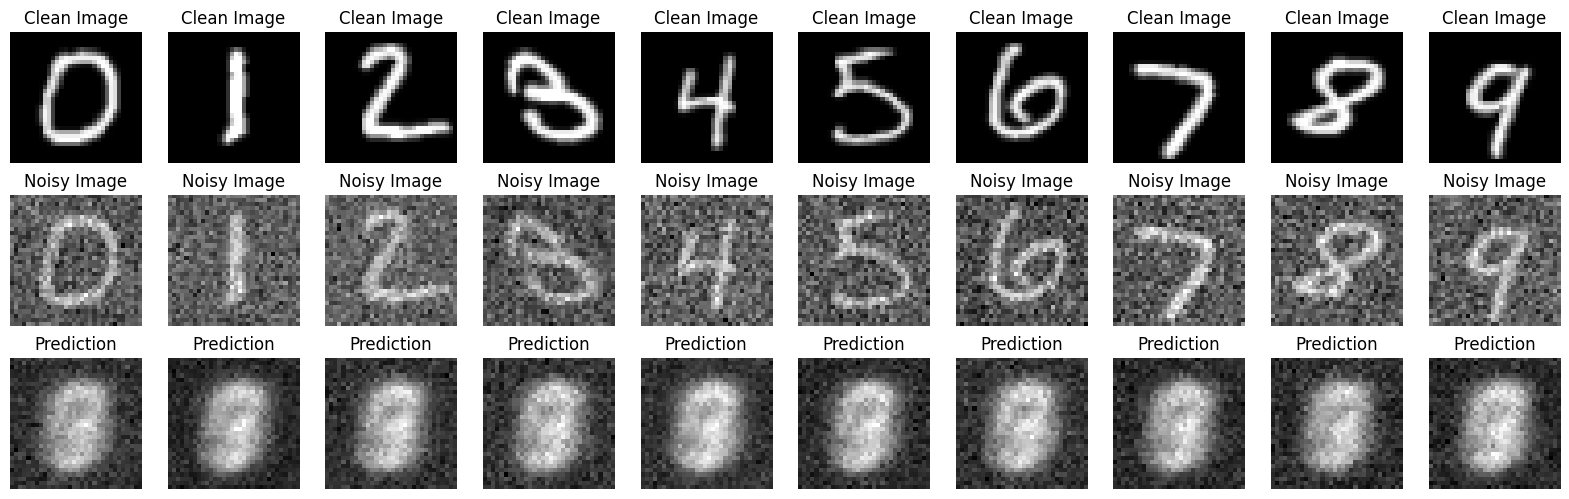

In [15]:
# Load the trained model
model = DenoisingNet().to(device)  # Instantiate the model
model.load_state_dict(torch.load('model_weights.pth'))  # Load the weights

# Get some test data
examples = enumerate(test_loader)
_, (clean_example, noisy_example, labels_example) = next(examples)

# Make a prediction with the trained network
outputs = model(noisy_example.to(device))  # Make sure to move your inputs to the device

# Move outputs back to cpu for plotting
outputs = outputs.cpu()

# Plot the first 10 test images, noisy images and their corresponding predictions
fig, axs = plt.subplots(3, 10, figsize=(20, 6))

for i in range(10):
    # Plot the clean image
    axs[0, i].imshow(clean_example[i].view(32, 32).detach().numpy(), cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title('Clean Image')

    # Plot the noisy image
    axs[1, i].imshow(noisy_example[i].view(32, 32).detach().numpy(), cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title('Noisy Image')

    # Plot the prediction
    axs[2, i].imshow(outputs[i].view(32, 32).detach().numpy(), cmap='gray')
    axs[2, i].axis('off')
    axs[2, i].set_title('Prediction')

plt.show()

# Exercise 7